In [1]:
# !pip install japanize-matplotlib 

In [2]:
exp = "exp050_llama"
device_id = 1

In [3]:
import glob
import os
import sys
from base64 import b64decode
from io import BytesIO
from PIL import Image

from transformers import (
    AutoTokenizer,
    CLIPImageProcessor,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    AutoModelForCausalLM
)
import datasets
import torch
from torch.utils.data import Dataset
import yaml
import deepspeed
import fire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from peft import LoraConfig, get_peft_config, get_peft_model


from git_llm.git_opt import GitOPTForCausalLM, GitOPTConfig
from git_llm.git_llama import GitLlamaForCausalLM, GitLlamaConfig

[2023-08-09 03:11:35,691] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
sys.path.append('..')
from train import load_model, apply_lora_model

# Functions

In [5]:
def generate_text(model, data):
    eos_token_id_list = [
        supervised_test_dataset.processor.tokenizer.pad_token_id,
        supervised_test_dataset.processor.tokenizer.eos_token_id,
    ]
    with torch.no_grad():
        out = model.generate(**data, max_length=256, do_sample=False, temperature=0., eos_token_id=eos_token_id_list)
        return supervised_test_dataset.processor.tokenizer.batch_decode(out)

# SupervisedDataset
class SupervisedDataset(Dataset):
    """Dataset for supervised learning"""

    def __init__(
        self,
        model_name: str,
        vision_model_name: str,
        loaded_dataset: datasets.GeneratorBasedBuilder,
        max_length: int = 128,
    ):
        super(SupervisedDataset, self).__init__()
        self.loaded_dataset = loaded_dataset
        self.max_length = max_length

        self.processor = AutoProcessor.from_pretrained("microsoft/git-base")
        self.processor.image_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
        self.processor.tokenizer = AutoTokenizer.from_pretrained(
            model_name, padding_side="right", use_fast=False
        )
        if "llama" in model_name:
            self.processor.tokenizer.pad_token = self.processor.tokenizer.eos_token

    def __len__(self) -> int:
        return len(self.loaded_dataset)

    def __getitem__(self, index) -> dict:
        # cf: https://huggingface.co/datasets/MMInstruction/M3IT#data-instances
        row = self.loaded_dataset[index]

        instruction = row["instruction"]  # str
        question = row["inputs"]  # str
        answer = row["outputs"]  # str
        full_text = f"##Instruction: {instruction} ##Question: {question} ##Answer: {answer}"
        text = f"##Instruction: {instruction} ##Question: {question} ##Answer:"

        # imageのロード
        image_base64_str_list = row["image_base64_str"]  # str (base64)
        img = Image.open(BytesIO(b64decode(image_base64_str_list[0])))

        inputs = self.process_data(text, img)

        return inputs, img, text, full_text

    def process_data(self, text, img):
        inputs = self.processor(
            text,
            img,
            return_tensors="pt",
            # max_length=self.max_length,
            # padding="max_length",
            truncation=True,
        )
        inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
        inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
        inputs["labels"] = None
        return inputs

# Load configs

In [6]:
config_file = f"../configs/training_config_{exp}.yml"

# get config
with open(config_file, "r") as i_:
    config = yaml.safe_load(i_)


# model
model_name = config["settings"]["model_name"]
vision_model_name = config["settings"]["vision_model_name"]
num_image_with_embedding = config["settings"]["num_image_with_embedding"]

keys_finetune = config["settings"]["keys_finetune"]

# Load a pretrained model

In [7]:
model = load_model(model_name, vision_model_name, num_image_with_embedding)

# lora
if config["use_lora"]:
    keys_finetune.append("lora")
    model = apply_lora_model(model, model_name, config)

weight = {}
weight_path = glob.glob(f'../output/{exp}/checkpoint*/pytorch*.bin')
for w in weight_path:
    weight_temp = torch.load(w, map_location="cpu")
    weight.update(weight_temp)
model.load_state_dict(weight, strict=False)

model.eval()
model.to(f"cuda:{device_id}")
print("Complete preparing an eval model")

You are using a model of type llama to instantiate a model of type git_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GitLlamaForCausalLM were not initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf and are newly initialized: ['model.image_encoder.vision_model.encoder.layers.7.layer_norm1.weight', 'model.image_encoder.vision_model.encoder.layers.4.mlp.fc1.bias', 'model.image_encoder.vision_model.encoder.layers.1.mlp.fc1.weight', 'model.image_encoder.vision_model.encoder.layers.8.self_attn.v_proj.bias', 'model.image_encoder.vision_model.encoder.layers.2.mlp.fc2.weight', 'model.image_encoder.vision_model.encoder.layers.4.layer_norm2.bias', 'model.image_encoder.vision_model.encoder.layers.3.self_attn.q_proj.bias', 'model.image_encoder.vision_model.encoder.layers.0.self_attn.out_proj.bias', 'model.image_encoder.vision_model.encoder.layers.6.self_attn.q_proj.bias', 'model.image_encoder.vision_model.encoder.layers.9.self_attn.out_proj.weight', 'model.image_encoder.vision_model.encoder.layers.9.self_attn.q_proj.weight', 'model.image_encoder.vision_model.encoder.layers.3.mlp

Complete preparing an eval model


# Show visual words

Found cached dataset m3_it (/home/y_inoue/.cache/huggingface/datasets/MMInstruction___m3_it/coco/1.0.0/631dfd20153e0fbacb50b0239d4a71727503813fa0e821ba5ab399bed706034e)


  0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


--------------------


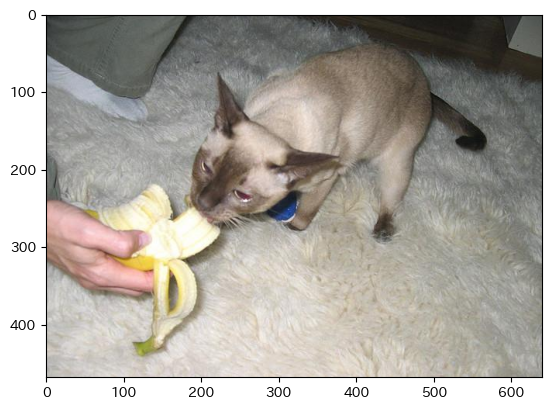

In [8]:
# Load data
coco_datasets = datasets.load_dataset("MMInstruction/M3IT", "coco")
test_dataset = coco_datasets["test"]
supervised_test_dataset = SupervisedDataset(model_name, vision_model_name, test_dataset, 256)
inputs, image, text, full_text = supervised_test_dataset[200]

# Make vocab features
ids = range(supervised_test_dataset.processor.tokenizer.vocab_size)
all_ids = torch.tensor([i for i in ids]).to(f"cuda:{device_id}")
token_id_to_features = model.model.embed_tokens(all_ids)

# Do inference
pixel_values = inputs["pixel_values"]
out_vit = model.model.image_encoder(pixel_values).last_hidden_state
out_vit = model.model.visual_projection(out_vit)

# Dot product
nearest_token = out_vit[0] @ token_id_to_features.T

# Print result
print('-'*20)
plt.figure()
plt.imshow(np.array(image))
plt.show()
plt.clf()
plt.close()
visual_out = nearest_token.argmax(-1).cpu().numpy()
decoded_text = supervised_test_dataset.processor.tokenizer.batch_decode(visual_out)

In [9]:
print(decoded_text)

['otr', 'eg', 'anto', 'rix', 'Nas', 'Enum', 'せ', 'せ', 'atura', 'mess', 'Abr', 'せ', 'worden', 'せ', 'Da', 'mess', 'anto', 'Abr', 'worden', 'mess', 'mess', 'Enum', 'atura', 'atura', 'atura', 'atura', 'enumer', 'atura', 'orp', 'mess', 'ʊ', 'mess', 'せ', 'enumer', 'mess', 'bell', 'atura', '那', 'bell', 'Cat', 'atura', 'atura', 'mess', 'enas', 'enas', 'mess', 'boldmath', '花', 'atura', 'atura', 'mess', 'atura', 'Abr', 'atura', 'atura', 'atura', '梅', 'составе', 'せ', 'せ', 'ワ', 'white', 'bell', 'enumer', 'atura', 'atura', 'atura', 'atura', 'atura', 'atura', 'clud', 'せ', 'Enum', 'Bac', 'olit', 'bell', 'bell', 'racc', 'white', 'oux', 'enumer', 'atura', 'atura', 'mess', 'bell', 'mitt', 'Fur', 'Griff', 'bell', 'bell', 'ワ', 'ワ', '岩', '岩', '<0xA9>', 'atura', 'atura', 'mess', 'mess', 'Branch', 'Branch', 'Braun', 'imper', '良', '親', 'volt', 'atura', 'agua', 'mess', 'mess', 'boldmath', 'mess', 'mess', 'honneur', 'bell', 'loat', 'Vlad', 'agua', 'nach', 'enumer', 'mess', 'atura', 'Bac', 'mess', '岩', 'mess', '

In [10]:
print(pd.Series(decoded_text).value_counts())

mess        43
atura       29
せ           10
Branch      10
Enum         9
bell         9
worden       7
enumer       7
岩            4
представ     4
oco          4
Abr          3
ワ            3
anto         2
boldmath     2
enas         2
white        2
Atlantic     2
Bac          2
loat         2
agua         2
']['         2
uras         2
honneur      2
rix          1
梅            1
составе      1
Cat          1
花            1
Da           1
orp          1
ʊ            1
那            1
otr          1
Nas          1
eg           1
clud         1
oux          1
mitt         1
olit         1
racc         1
volt         1
親            1
良            1
imper        1
Braun        1
<0xA9>       1
Fur          1
Griff        1
nach         1
feelings     1
Vlad         1
gro          1
cope         1
intendo      1
操            1
vol          1
Name: count, dtype: int64


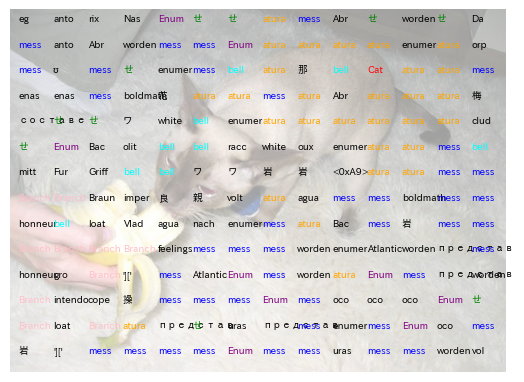

In [11]:
n_patches = 14
IMAGE_HIEGHT, IMAGE_WIDTH, _ = np.array(image).shape

y_list = np.arange(15, IMAGE_HIEGHT, IMAGE_HIEGHT//n_patches)
x_list = np.arange(10, IMAGE_WIDTH, IMAGE_WIDTH//n_patches)

plt.figure()
plt.axis("off")
plt.imshow(np.array(image), alpha=0.4)
for index in np.arange(n_patches ** 2):
    y_pos = index // n_patches
    x_pos = index - y_pos * n_patches
    
    y = y_list[y_pos]
    x = x_list[x_pos]

    # 1 token目はbos tokenなので除く
    word = decoded_text[index + 1]

    # 単語ごとに適当に色分けしてプロット
    if word == "mess":
        plt.annotate(word, (x, y), size=7, color="blue")
    elif word == "atura":
        plt.annotate(word, (x, y), size=7, color="orange")
    elif word == "Cat":
        plt.annotate(word, (x, y), size=7, color="red")
    elif word == "せ":
        plt.annotate(word, (x, y), size=7, color="green")
    elif word == "Branch":
        plt.annotate(word, (x, y), size=7, color="pink")
    elif word == "Enum":
        plt.annotate(word, (x, y), size=7, color="purple")
    elif word == "bell":
        plt.annotate(word, (x, y), size=7, color="cyan")
    else:
        plt.annotate(word, (x, y), size=7, color="black")

plt.show()
plt.clf()
plt.close()

In [12]:
# 正しくテキストを復元できるか確認
text__ = torch.tensor(supervised_test_dataset.processor.tokenizer(full_text)["input_ids"]).to(f"cuda:{device_id}")
out_embed = model.model.embed_tokens(text__)


nearest_token = out_embed @ token_id_to_features.T

out_token = nearest_token.argmax(-1).cpu().numpy()
decoded_text = supervised_test_dataset.processor.tokenizer.decode(out_token)

print('-------')
print('Decoded text:')
print(decoded_text)
print('-------')
print('Original text:')
print(full_text)

-------
Decoded text:
<s>##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer: a cat that is eating some kind of banana
-------
Original text:
##Instruction: Offer a succinct explanation of the picture presented. ##Question:  ##Answer: a cat that is eating some kind of banana
